In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation,Concatenate
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn import manifold, datasets
from sklearn.utils import check_random_state
from sklearn import metrics

Using TensorFlow backend.


In [2]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')
#pick up the 1st image to have a look   
path_now = path[0]
a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])
Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

Image_RGB = np.empty((len(Image),64,64,3))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][3],Image[i][2],Image[i][1]),axis=-1)


for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*3):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[i-1])
        
Image_RGB -= np.mean(Image_RGB)
Image_RGB /= np.max(Image_RGB)

815


In [3]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB
index = [i for i in range(len(data))]
#random.shuffle(index)
train_data = data[index]
train_label = label[index]
Class = Class[index]
Redshift = Redshift[index]
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)

train_data.shape: (14142, 64, 64, 3)
train_label.shape: (14142, 3)


# double Peak Pseudo Wasserstein loss ;2b revised

In [34]:
batch_size =100
latent_dim = 1
nb_epoch = 50  
epsilon_std = 0.5
intermediate_dim =256
original_dim = 64*64
LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)
#USE = 'autoencoder'
USE = 'vae'
#encoder:
input_img = Input(shape=(64,64,3))


x = Conv2D(40, (3, 3),padding='same',kernel_initializer='normal')(input_img)
x = Activation(LRelu)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(x)
x = Activation(LRelu)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(x)
x = Activation(LRelu)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(x)
x = Activation(LRelu)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(x)
x = Activation(LRelu)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(x)
h_1 = Dense(intermediate_dim, activation=LRelu)(visual)

#z_mean = Dense(latent_dim)(h_1)
z_mean = Dense(latent_dim,activation='tanh')(h_1)
z_log_var = Dense(latent_dim)(h_1)
z_mean_2 = Dense(latent_dim)(h_1)
z_log_var_2 = Dense(latent_dim)(h_1)
z_mean_con = Concatenate()([z_mean,z_mean_2])
def sampling(args):
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
z_2 = Lambda(sampling, output_shape=(latent_dim,))([z_mean_2, z_log_var_2])


z_combine = Concatenate()([z,z_2])
h_3 = Dense(intermediate_dim,activation=LRelu)(z_combine)#for VAE

    
h_4 = Dense(20*2*2,activation=LRelu)(h_3)
h_5 = Reshape((2,2,20))(h_4)


x = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(h_5)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(40, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
checkpoint = keras.callbacks.ModelCheckpoint('model_save_classification_BN.h5',monitor = 'val_loss',verbose = 1,save_best_only = True)

#def vae_loss(x, decoded):  
    #xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    #kl_loss = - 0.5 * K.sum(1 + z_log_var - 0.5*K.square(z_mean-2) - 0.5*K.square(z_mean+2) - K.exp(z_log_var), axis=-1) 
    #kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean)  - K.exp(z_log_var), axis=-1) 
    #return 1*xent_loss + 100*kl_loss 
def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    w_loss_d1_mean = K.sum(K.square((z_mean)), axis=-1)
    #Sigma = np.exp(z_log_var/2)
    #kl_loss_2 = K.sum(K.sqrt(K.constant(np.sqrt(2.0))*(K.constant(1.0)+K.constant(2.0)/K.exp(z_log_var/K.constant(2.0))) - (K.constant(8.0)*K.exp(-K.constant(1.0)/(K.exp(z_log_var)+K.constant(1.0))))/(K.sqrt(K.exp(z_log_var)+K.constant(1.0)))), axis=-1)
    w_loss_d1_var = K.sum(K.constant(1)/(K.exp(z_log_var) + K.constant(1))*(K.exp(-(K.constant(2) + K.constant(2)*z_mean + K.square(z_mean) + K.constant(2)*K.square(K.exp(z_log_var/K.constant(2))))/((K.exp(z_log_var) + K.constant(1))))*(-K.constant(4)*K.exp((K.constant(1) + K.constant(2)*K.exp(z_log_var))/(K.constant(1) +K.exp(z_log_var))) - K.constant(4)*K.exp((K.constant(1) + K.constant(4)*z_mean + K.constant(2)*K.exp(z_log_var))/(K.constant(1) + K.exp(z_log_var))) + K.sqrt(K.constant(2))*K.exp((z_mean*(K.constant(2) + z_mean))/(K.exp(z_log_var) + K.constant(1)))*K.sqrt(K.exp(z_log_var) + K.constant(1)) + K.sqrt(K.constant(2))*K.exp((K.constant(2)*(K.constant(1) + z_mean) + K.square(z_mean) + K.constant(2)*K.square(K.exp(z_log_var/K.constant(2))))/(K.exp(z_log_var) + K.constant(1))))), axis=-1)
    w_loss_d2_mean = K.sum(K.square((z_mean_2)), axis=-1)
    w_loss_d2_var = K.sum(K.constant(2)*K.sqrt(K.constant(2))*(K.constant(1)+K.constant(1)/K.exp(z_log_var_2/K.constant(2)))-K.constant(4)*K.exp(-(K.square(z_mean_2)/(K.exp(z_log_var_2)+K.constant(1))))/K.sqrt(K.exp(z_log_var_2)+K.constant(1)) , axis=-1)
    return 1*xent_loss +10*w_loss_d1_mean+10*w_loss_d1_var + w_loss_d2_mean + w_loss_d2_var
    

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [37]:
vae.fit(train_data[:12000], train_data[:12000],
        shuffle=True,
        epochs=nb_epoch,
        batch_size=batch_size,
        validation_data=(train_data[12000:14100],train_data[12000:14100]),callbacks=[EarlyStopping])

Train on 12000 samples, validate on 2100 samples
Epoch 1/50
12000/12000 [==============================] - 20s - loss: -8055.1577 - val_loss: -8045.9833
Epoch 2/50
12000/12000 [==============================] - 19s - loss: -8056.2750 - val_loss: -7975.5345
Epoch 3/50
12000/12000 [==============================] - 20s - loss: -8061.1881 - val_loss: -8027.9748
Epoch 4/50
12000/12000 [==============================] - 19s - loss: -8060.3701 - val_loss: -8009.0467
Epoch 5/50
12000/12000 [==============================] - 20s - loss: -8070.0948 - val_loss: -8024.5339
Epoch 6/50
12000/12000 [==============================] - 19s - loss: -8061.8096 - val_loss: -8041.9412
Epoch 7/50
12000/12000 [==============================] - 19s - loss: -8052.1849 - val_loss: -8039.2101
Epoch 8/50
12000/12000 [==============================] - 19s - loss: -8069.5651 - val_loss: -8054.0071
Epoch 9/50
12000/12000 [==============================] - 19s - loss: -8075.7163 - val_loss: -7921.1216
Epoch 10/50
120

KeyboardInterrupt: 

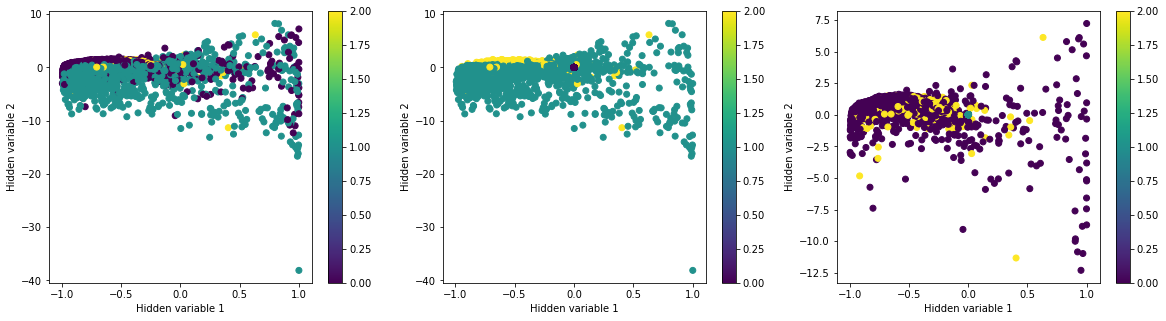

In [38]:
lower_lim = 0
upper_lim = 14100

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean_con)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

# quadra-peak pseudo Wasserstein loss (same size)【revising】

In [223]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 0.1
intermediate_dim =256
original_dim = 64*64
LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)
#USE = 'autoencoder'
USE = 'vae'
#encoder:
input_img = Input(shape=(64,64,3))


x = Conv2D(40, (3, 3),padding='same',kernel_initializer='normal')(input_img)
x = Activation(LRelu)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(x)
x = Activation(LRelu)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(x)
x = Activation(LRelu)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(x)
x = Activation(LRelu)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(x)
x = Activation(LRelu)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(x)
h_1 = Dense(intermediate_dim, activation=LRelu)(visual)

#z_mean = Dense(latent_dim)(h_1)
z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)
#z_mean_2 = Dense(latent_dim)(h_1)
#z_log_var_2 = Dense(latent_dim)(h_1)
#z_mean_con = Concatenate()([z_mean,z_mean_2])
def sampling(args):
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
#z_2 = Lambda(sampling, output_shape=(latent_dim,))([z_mean_2, z_log_var_2])


#z_combine = Concatenate()([z,z_2])
h_3 = Dense(intermediate_dim,activation=LRelu)(z)#for VAE

    
h_4 = Dense(20*2*2,activation=LRelu)(h_3)
h_5 = Reshape((2,2,20))(h_4)


x = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(h_5)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(40, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
checkpoint = keras.callbacks.ModelCheckpoint('model_save_classification_BN.h5',monitor = 'val_loss',verbose = 1,save_best_only = True)

#def vae_loss(x, decoded):  
    #xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    #kl_loss = - 0.5 * K.sum(1 + z_log_var - 0.5*K.square(z_mean-2) - 0.5*K.square(z_mean+2) - K.exp(z_log_var), axis=-1) 
    #kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean)  - K.exp(z_log_var), axis=-1) 
    #return 1*xent_loss + 100*kl_loss 
def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    w_loss_d1_mean = K.sum(K.square((z_mean)), axis=-1)
    #Sigma = np.exp(z_log_var/2)
    #kl_loss_2 = K.sum(K.sqrt(K.constant(np.sqrt(2.0))*(K.constant(1.0)+K.constant(2.0)/K.exp(z_log_var/K.constant(2.0))) - (K.constant(8.0)*K.exp(-K.constant(1.0)/(K.exp(z_log_var)+K.constant(1.0))))/(K.sqrt(K.exp(z_log_var)+K.constant(1.0)))), axis=-1)
    m = K.constant(2)
    s = K.constant(1)
    w_loss_d1_var = K.sum((        
        K.exp(-K.square(m/s)-K.square(z_mean)/K.constant(2)/(K.square(s)+K.exp(z_log_var)))*
            (
            -K.constant(2*np.sqrt(2))*K.exp((m*(-K.constant(2)*z_mean*K.square(s)+m*(K.square(s)+K.constant(2)*K.exp(z_log_var))))/(K.constant(2)*K.square(s)*(K.square(s)+K.exp(z_log_var))))
            -K.constant(2*np.sqrt(2))*K.exp((m*(K.constant(2)*z_mean*K.square(s)+m*(K.square(s)+K.constant(2)*K.exp(z_log_var))))/(K.constant(2)*K.square(s)*(K.square(s)+K.exp(z_log_var))))
            +K.exp(z_log_var/2)*K.exp((K.square(z_mean))/(K.constant(2)*(K.square(s)+K.exp(z_log_var))))*K.sqrt(K.constant(1)/K.square(s)+K.constant(1)/K.exp(z_log_var))
            +K.exp(K.square(m/s)+(K.square(z_mean))/(K.constant(2)*(K.square(s)+K.exp(z_log_var))))*K.exp(z_log_var/2)*s*(K.constant(1)/s+K.constant(2)/K.exp(z_log_var/2))*K.sqrt(K.constant(1)/K.square(s)+K.constant(1)/K.exp(z_log_var))
            )
        )
        /(K.constant(4)*K.constant(np.sqrt(np.pi))*s*K.exp(z_log_var/2)*K.sqrt(K.constant(1)/K.square(s)+K.constant(1)/K.exp(z_log_var))), axis=-1)
            #w_loss_d2_mean = K.sum(K.square((z_mean_2)), axis=-1)
    #w_loss_d2_var = K.sum(K.constant(2)*K.sqrt(K.constant(2))*(K.constant(1)+K.constant(1)/K.exp(z_log_var_2/K.constant(2)))-K.constant(4)*K.exp(-(K.square(z_mean_2)/(K.exp(z_log_var_2)+K.constant(1))))/K.sqrt(K.exp(z_log_var_2)+K.constant(1)) , axis=-1)
    return 1*xent_loss +w_loss_d1_mean+w_loss_d1_var 
    

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss
RMSprop = keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-09, decay=1e-7)

if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer=RMSprop, loss=vae_loss) 

In [224]:
#(
#K.exp(-K.square(m/s)-K.square(z_mean)/K.constant(2)/(K.square(s)+K.exp(z_log_var)))*
#    (
#    -K.constant(2*np.sqrt(2))*K.exp((m*(-K.constant(2)*z_mean*K.square(s)+m*(K.square(s)+K.constant(2)*K.exp(z_log_var))))/(K.constant(2)*K.square(s)*(K.square(s)+K.exp(z_log_var))))
#    -K.constant(2*np.sqrt(2))*K.exp((m*(K.constant(2)*z_mean*K.square(s)+m*(K.square(s)+K.constant(2)*K.exp(z_log_var))))/(K.constant(2)*K.square(s)*(K.square(s)+K.exp(z_log_var))))
#    +K.exp(z_log_var/2)*K.exp((K.square(z_mean))/(K.constant(2)*(K.square(s)+K.exp(z_log_var))))*K.sqrt(K.constant(1)/K.square(s)+K.constant(1)/K.exp(z_log_var))
#    +K.exp(K.square(m/s)+(K.square(z_mean))/(K.constant(2)*(K.square(s)+K.exp(z_log_var))))*K.exp(z_log_var/2)*s*(K.constant(1)/s+K.constant(2)/K.exp(z_log_var/2))*K.sqrt(K.constant(1)/K.square(s)+K.constant(1)/K.exp(z_log_var))
#    )
#)
#/(K.constant(4)*K.constant(np.sqrt(np.pi))*s*K.exp(z_log_var/2)*K.sqrt(K.constant(1)/K.square(s)+K.constant(1)/K.exp(z_log_var)))

In [225]:
vae.fit(train_data[:12000], train_data[:12000],
        shuffle=True,
        epochs=nb_epoch,
        batch_size=batch_size,
        validation_data=(train_data[12000:14100],train_data[12000:14100]),callbacks=[EarlyStopping])

Train on 12000 samples, validate on 2100 samples
Epoch 1/50
12000/12000 [==============================] - 24s - loss: -6836.7172 - val_loss: -7492.2473
Epoch 2/50
12000/12000 [==============================] - 20s - loss: -7858.9732 - val_loss: -7897.5419
Epoch 3/50
12000/12000 [==============================] - 20s - loss: -7982.8504 - val_loss: -7859.7666
Epoch 4/50
12000/12000 [==============================] - 20s - loss: -8009.6236 - val_loss: -7975.2228
Epoch 5/50
12000/12000 [==============================] - 20s - loss: -8029.0518 - val_loss: -8005.0421
Epoch 6/50
12000/12000 [==============================] - 20s - loss: -8039.5365 - val_loss: -8009.1049
Epoch 7/50
12000/12000 [==============================] - 20s - loss: -8048.4269 - val_loss: -8022.3643
Epoch 8/50
12000/12000 [==============================] - 20s - loss: -8054.6837 - val_loss: -8028.9464
Epoch 9/50
12000/12000 [==============================] - 20s - loss: -8062.2304 - val_loss: -8025.6574
Epoch 10/50
120

KeyboardInterrupt: 

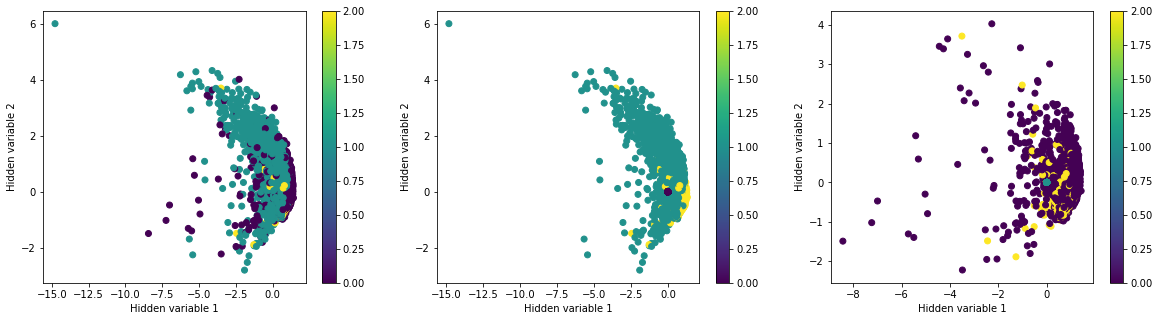

In [226]:
lower_lim = 0
upper_lim = 14100

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [227]:
lower_lim = 0
upper_lim = 14000


vis = Model(input_img, z_mean)
# display a 2D plot of the digit classes in the latent space
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)


plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

KeyboardInterrupt: 

8000
AUC: 0.725739193478


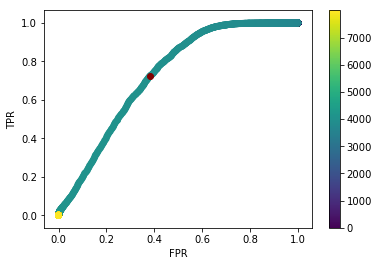

In [191]:
Y_pred = -Y_pred
thr_min = -4
thr_max = 4
test_accuracy = 0.001
test_range = int((thr_max - thr_min)/test_accuracy)
print(test_range)
FP = []
TP = []
TN = []
FN = []
TA = np.ones((Y_pred.shape[0],))
TA[Class[lower_lim:upper_lim] ==0 ] = 0
TA[Class[lower_lim:upper_lim] ==2 ] = 0

for i in range(test_range):
    FP_temp = np.zeros((Y_pred.shape[0]))
    TP_temp = np.zeros((Y_pred.shape[0]))
    TN_temp = np.zeros((Y_pred.shape[0]))
    FN_temp = np.zeros((Y_pred.shape[0]))
    LA = np.zeros((Y_pred.shape[0],))
    thr_now = thr_min+ i*test_accuracy
    LA[Y_pred[:,0] > thr_now] = 1
    for j in range(Y_pred.shape[0]):
        if LA[j]==0:
            if TA[j]==1:
                FN_temp[j] = 1
            else:
                TN_temp[j] = 1
        else:
            if TA[j] == 1:
                TP_temp[j] = 1
            else:
                FP_temp[j] = 1
    FP.append(FP_temp)
    TP.append(TP_temp)
    TN.append(TN_temp)
    FN.append(FN_temp)
    
TPR = np.zeros((test_range,))
FPR = np.zeros((test_range,))
TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

plt.scatter(FPR,TPR,c=[i for i in range(test_range)])

plt.colorbar()
plt.scatter(FPR[np.argmin((TPR-1)**2 + FPR**2)],TPR[np.argmin((TPR-1)**2 + FPR**2)],c=0,cmap='OrRd_r')
plt.xlabel('FPR')
plt.ylabel('TPR')
#argmax, OrRed

print("AUC:",metrics.auc(FPR, TPR))

In [192]:
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(hid_pred)

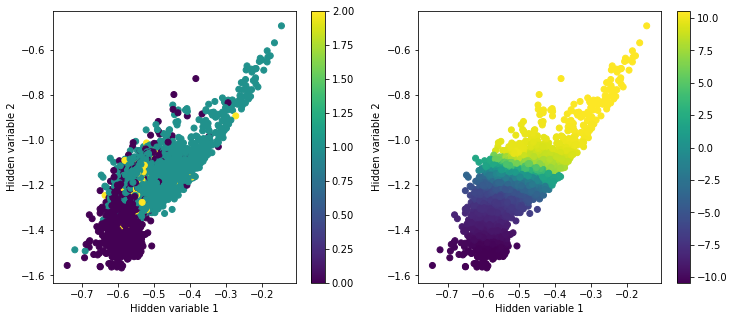

In [194]:
plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

# quadra-peak pseudo Wasserstein loss with different size

In [63]:
batch_size =100
latent_dim = 1
nb_epoch = 50  
epsilon_std = 0.3
intermediate_dim =256
original_dim = 64*64
LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)
#USE = 'autoencoder'
USE = 'vae'
#encoder:
input_img = Input(shape=(64,64,3))


x = Conv2D(40, (3, 3),padding='same',kernel_initializer='normal')(input_img)
x = Activation(LRelu)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(x)
x = Activation(LRelu)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(x)
x = Activation(LRelu)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(x)
x = Activation(LRelu)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(x)
x = Activation(LRelu)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(x)
h_1 = Dense(intermediate_dim, activation=LRelu)(visual)

#z_mean = Dense(latent_dim)(h_1)
z_mean = Dense(latent_dim,activation='tanh')(h_1)
z_log_var = Dense(latent_dim)(h_1)
z_mean_2 = Dense(latent_dim,activation='tanh')(h_1)

def div2(args):
    z_mean_2 = args
    return z_mean_2/K.constant(2)

z_mean_2 = Lambda(div2,output_shape=(latent_dim,))(z_mean_2)
z_log_var_2 = Dense(latent_dim)(h_1)
z_mean_con = Concatenate()([z_mean,z_mean_2])
def sampling(args):
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
z_2 = Lambda(sampling, output_shape=(latent_dim,))([z_mean_2, z_log_var_2])


z_combine = Concatenate()([z,z_2])
h_3 = Dense(intermediate_dim,activation=LRelu)(z_combine)#for VAE

    
h_4 = Dense(20*2*2,activation=LRelu)(h_3)
h_5 = Reshape((2,2,20))(h_4)


x = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(h_5)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(40, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
checkpoint = keras.callbacks.ModelCheckpoint('model_save_classification_BN.h5',monitor = 'val_loss',verbose = 1,save_best_only = True)

#def vae_loss(x, decoded):  
    #xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    #kl_loss = - 0.5 * K.sum(1 + z_log_var - 0.5*K.square(z_mean-2) - 0.5*K.square(z_mean+2) - K.exp(z_log_var), axis=-1) 
    #kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean)  - K.exp(z_log_var), axis=-1) 
    #return 1*xent_loss + 100*kl_loss 
def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    w_loss_d1_mean = K.sum(K.square((z_mean)), axis=-1)
    #Sigma = np.exp(z_log_var/2)
    #kl_loss_2 = K.sum(K.sqrt(K.constant(np.sqrt(2.0))*(K.constant(1.0)+K.constant(2.0)/K.exp(z_log_var/K.constant(2.0))) - (K.constant(8.0)*K.exp(-K.constant(1.0)/(K.exp(z_log_var)+K.constant(1.0))))/(K.sqrt(K.exp(z_log_var)+K.constant(1.0)))), axis=-1)
    w_loss_d1_var = K.sum(K.constant(1)/(K.exp(z_log_var) + K.constant(1))*(K.exp(-(K.constant(2) + K.constant(2)*z_mean + K.square(z_mean) + K.constant(2)*K.square(K.exp(z_log_var/K.constant(2))))/((K.exp(z_log_var) + K.constant(1))))*(-K.constant(4)*K.exp((K.constant(1) + K.constant(2)*K.exp(z_log_var))/(K.constant(1) +K.exp(z_log_var))) - K.constant(4)*K.exp((K.constant(1) + K.constant(4)*z_mean + K.constant(2)*K.exp(z_log_var))/(K.constant(1) + K.exp(z_log_var))) + K.sqrt(K.constant(2))*K.exp((z_mean*(K.constant(2) + z_mean))/(K.exp(z_log_var) + K.constant(1)))*K.sqrt(K.exp(z_log_var) + K.constant(1)) + K.sqrt(K.constant(2))*K.exp((K.constant(2)*(K.constant(1) + z_mean) + K.square(z_mean) + K.constant(2)*K.square(K.exp(z_log_var/K.constant(2))))/(K.exp(z_log_var) + K.constant(1))))), axis=-1)
    w_loss_d2_mean = K.sum(K.square((z_mean_2)), axis=-1)
    w_loss_d2_var = K.sum(K.constant(1)/(K.exp(z_log_var_2) + K.constant(1))*(K.exp(-(K.constant(2) + K.constant(2)*z_mean_2 + K.square(z_mean_2) + K.constant(2)*K.square(K.exp(z_log_var_2/K.constant(2))))/((K.exp(z_log_var_2) + K.constant(1))))*(-K.constant(4)*K.exp((K.constant(1) + K.constant(2)*K.exp(z_log_var_2))/(K.constant(1) +K.exp(z_log_var_2))) - K.constant(4)*K.exp((K.constant(1) + K.constant(4)*z_mean_2 + K.constant(2)*K.exp(z_log_var_2))/(K.constant(1) + K.exp(z_log_var_2))) + K.sqrt(K.constant(2))*K.exp((z_mean_2*(K.constant(2) + z_mean_2))/(K.exp(z_log_var_2) + K.constant(1)))*K.sqrt(K.exp(z_log_var_2) + K.constant(1)) + K.sqrt(K.constant(2))*K.exp((K.constant(2)*(K.constant(1) + z_mean_2) + K.square(z_mean_2) + K.constant(2)*K.square(K.exp(z_log_var_2/K.constant(2))))/(K.exp(z_log_var_2) + K.constant(1))))), axis=-1)
    #w_loss_d2_var = K.sum(K.constant(2)*K.sqrt(K.constant(2))*(K.constant(1)+K.constant(1)/K.exp(z_log_var_2/K.constant(2)))-K.constant(4)*K.exp(-(K.square(z_mean_2)/(K.exp(z_log_var_2)+K.constant(1))))/K.sqrt(K.exp(z_log_var_2)+K.constant(1)) , axis=-1)
    return 1*xent_loss +w_loss_d1_mean+w_loss_d1_var + 0*w_loss_d2_mean + 0*w_loss_d2_var
    

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [64]:
vae.fit(train_data[:12000], train_data[:12000],
        shuffle=True,
        epochs=nb_epoch,
        batch_size=batch_size,
        validation_data=(train_data[12000:14100],train_data[12000:14100]),callbacks=[EarlyStopping])

Train on 12000 samples, validate on 2100 samples
Epoch 1/50
12000/12000 [==============================] - 22s - loss: -7228.3049 - val_loss: -7373.3990
Epoch 2/50
12000/12000 [==============================] - 20s - loss: -7620.3176 - val_loss: -7727.5234
Epoch 3/50
12000/12000 [==============================] - 20s - loss: -7812.6320 - val_loss: -7908.8851
Epoch 4/50
12000/12000 [==============================] - 20s - loss: -7921.1579 - val_loss: -7856.7879
Epoch 5/50
12000/12000 [==============================] - 20s - loss: -7983.4803 - val_loss: -7960.2939
Epoch 6/50
12000/12000 [==============================] - 20s - loss: -7960.6749 - val_loss: -7874.7372
Epoch 7/50
12000/12000 [==============================] - 20s - loss: -8003.7601 - val_loss: -7997.2311
Epoch 8/50
12000/12000 [==============================] - 20s - loss: -8014.3381 - val_loss: -7993.5291
Epoch 9/50
12000/12000 [==============================] - 20s - loss: -8021.1251 - val_loss: -8027.8205
Epoch 10/50
120

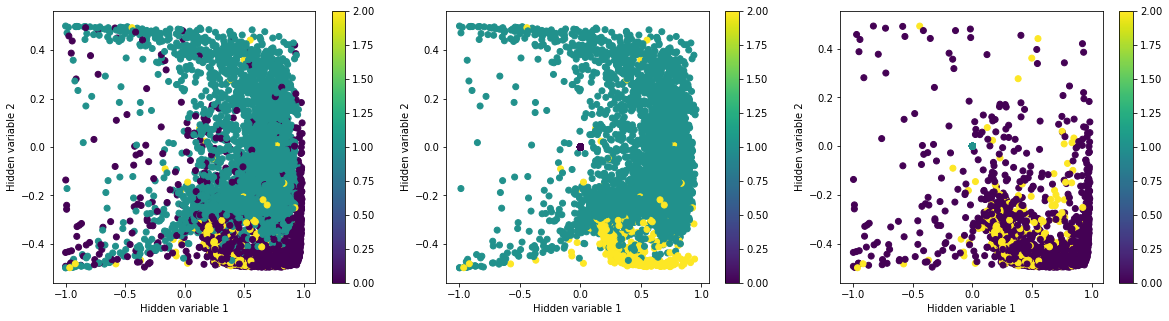

In [65]:
lower_lim = 0
upper_lim = 14100

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean_con)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

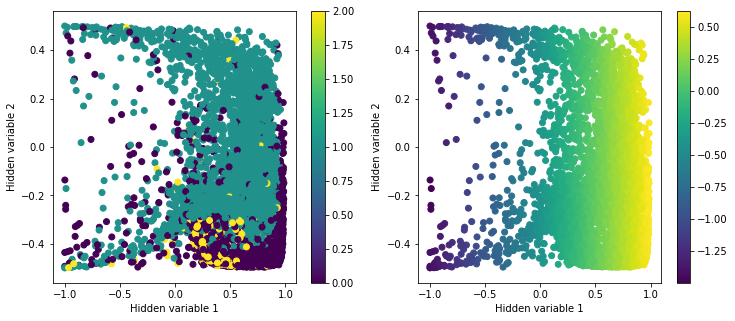

In [66]:
lower_lim = 0
upper_lim = 14000


vis = Model(input_img, z_mean_con)
# display a 2D plot of the digit classes in the latent space
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)


plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

# KL-divergence with mean penalty term

In [156]:
batch_size =100
latent_dim = 1
nb_epoch = 50  
epsilon_std = 0.1
intermediate_dim =256
original_dim = 64*64
LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)
#USE = 'autoencoder'
USE = 'vae'
#encoder:
input_img = Input(shape=(64,64,3))


x = Conv2D(40, (3, 3),padding='same',kernel_initializer='normal')(input_img)
x = Activation(LRelu)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(x)
x = Activation(LRelu)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(x)
x = Activation(LRelu)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(x)
x = Activation(LRelu)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(x)
x = Activation(LRelu)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(x)
h_1 = Dense(intermediate_dim, activation=LRelu)(visual)

#z_mean = Dense(latent_dim)(h_1)
z_mean_1 = Dense(latent_dim)(h_1)
z_log_var_1 = Dense(latent_dim)(h_1)
z_mean_2 = Dense(latent_dim)(h_1)
z_log_var_2 = Dense(latent_dim)(h_1)
z_mean_con = Concatenate()([z_mean_1,z_mean_2])
def sampling(args):
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z_1 = Lambda(sampling, output_shape=(latent_dim,))([z_mean_1, z_log_var_1])
z_2 = Lambda(sampling, output_shape=(latent_dim,))([z_mean_2, z_log_var_2])


z_combine = Concatenate()([z_1,z_2])
h_3 = Dense(intermediate_dim,activation=LRelu)(z_combine)#for VAE

    
h_4 = Dense(20*2*2,activation=LRelu)(h_3)
h_5 = Reshape((2,2,20))(h_4)


x = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(h_5)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(40, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
checkpoint = keras.callbacks.ModelCheckpoint('model_save_classification_BN.h5',monitor = 'val_loss',verbose = 1,save_best_only = True)

#def vae_loss(x, decoded):  
    #xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    #kl_loss = - 0.5 * K.sum(1 + z_log_var - 0.5*K.square(z_mean-2) - 0.5*K.square(z_mean+2) - K.exp(z_log_var), axis=-1) 
    #kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean)  - K.exp(z_log_var), axis=-1) 
    #return 1*xent_loss + 100*kl_loss 
def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    #kl_loss_d1 = - 0.5 * K.sum(1 + z_log_var_1 - K.square(z_mean_1)  - K.exp(z_log_var_1), axis=-1)
    m = K.constant(2)
    s = K.constant(1)
    kl_loss_d1 = K.sum(K.log(2*s/K.exp(z_log_var_1/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean_1))/((K.constant(2))*K.exp(z_log_var_1)))*K.exp(z_log_var_1/2) + K.sqrt(K.constant(np.pi/2))*z_mean_1*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean_1/K.constant(np.sqrt(2))/K.exp(z_log_var_1/2)))) )/(K.square(s))+(K.square(m-z_mean_1)+(K.exp(z_log_var_1/2)-s)*(K.exp(z_log_var_1/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
    kl_loss_d2 = K.sum(K.log(2*s/K.exp(z_log_var_2/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean_2))/((K.constant(2))*K.exp(z_log_var_2)))*K.exp(z_log_var_2/2) + K.sqrt(K.constant(np.pi/2))*z_mean_2*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean_2/K.constant(np.sqrt(2))/K.exp(z_log_var_2/2)))) )/(K.square(s))+(K.square(m-z_mean_2)+(K.exp(z_log_var_2/2)-s)*(K.exp(z_log_var_2/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
    #kl_loss_d2 = K.sum(K.log(2*s/K.exp(z_log_var_2/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean_2))/(K.square()*K.exp(z_log_var_2)))*K.exp(z_log_var_2/2) + K.sqrt(K.constant(np.pi/2))*z_mean_2*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean_2/K.constant(np.sqrt(2))/K.exp(z_log_var_2/2)))) )/(K.square(s)), axis=-1)
    return 1*xent_loss + 1*kl_loss_d1 + 1*kl_loss_d2
    

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [161]:
vae.fit(train_data[:12000], train_data[:12000],
        shuffle=True,
        epochs=nb_epoch,
        batch_size=batch_size,
        validation_data=(train_data[12000:14100],train_data[12000:14100]),callbacks=[EarlyStopping])

Train on 12000 samples, validate on 2100 samples
Epoch 1/50
12000/12000 [==============================] - 20s - loss: -8054.0325 - val_loss: -7978.6690
Epoch 2/50
12000/12000 [==============================] - 20s - loss: -8030.6607 - val_loss: -8037.3889
Epoch 3/50
12000/12000 [==============================] - 20s - loss: -8047.6365 - val_loss: -8050.9695
Epoch 4/50
12000/12000 [==============================] - 20s - loss: -8045.0080 - val_loss: -7997.4475
Epoch 5/50
12000/12000 [==============================] - 20s - loss: -8052.5213 - val_loss: -8082.5289
Epoch 6/50
12000/12000 [==============================] - 20s - loss: -8066.1194 - val_loss: -8065.3704
Epoch 7/50
12000/12000 [==============================] - 20s - loss: -8086.8526 - val_loss: -8020.2423
Epoch 8/50
12000/12000 [==============================] - 20s - loss: -8064.9425 - val_loss: -8060.1036
Epoch 9/50
12000/12000 [==============================] - 20s - loss: -8067.3505 - val_loss: -8075.7830
Epoch 10/50
120

In [162]:
#m = K.constant(0.0)
#s = K.constant(1.0)
#K.log((K.constant(2)*m*(-K.exp(-(K.square(z_mean_2))/(K.square(K.constant(2))*K.exp(z_log_var_2)))*K.exp(z_log_var_2/2) + K.sqrt(K.constant(np.pi/2))*z_mean_2*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean_2/K.constant(np.sqrt(2))/K.exp(z_log_var_2/2)))) )/(K.square(s)))



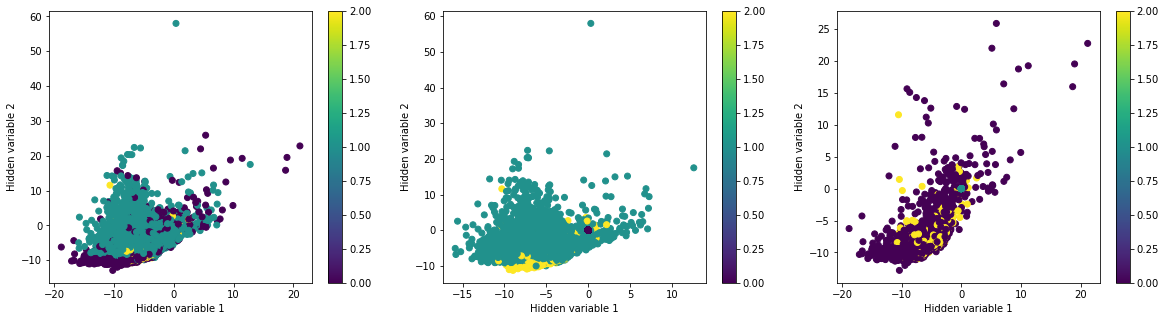

In [163]:
lower_lim = 0
upper_lim = 14100

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_combine)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [ ]:
#如果不work，下一步加一个中心均值的惩罚项

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   7.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   6.00000000e+00,   6.00000000e+00,
          5.00000000e+00,   5.00000000e+00,   9.00000000e+00,
          9.00000000e+00,   1.80000000e+01,   5.00000000e+00,
          1.30000000e+01,   1.90000000e+01,   1.70000000e+01,
          1.70000000e+01,   3.00000000e+01,   2.30000000e+01,
          2.50000000e+01,   2.90000000e+01,   6.20000000e+01,
          4.30000000e+01,   7.20000000e+01,   6.10000000e+01,
          7.10000000e+01,   8.90000000e+01,   1.26000000e+02,
          1.22000000e+02,   1.56000000e+02,   1.42000000e+02,
        

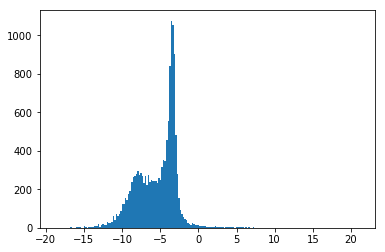

In [165]:
plt.hist(x_vis[:,0],200)

In [ ]:
#K.sum(K.log(2*s/K.exp(z_log_var_2/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean_2))/((K.constant(2))*K.exp(z_log_var_2)))*K.exp(z_log_var_2/2) + K.sqrt(K.constant(np.pi/2))*z_mean_2*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean_2/K.constant(np.sqrt(2))/K.exp(z_log_var_2/2)))) )/(K.square(s))+(K.square(m-z_mean_2)-(K.exp(z_log_var_2/2)-s)*(K.exp(z_log_var_2/2)+s))/(K.constant(2)*K.square(s))